In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import os
import random
from scipy.stats import skew

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(42) # Seed 고정

In [3]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

<Axes: xlabel='풍속 (m/s)', ylabel='Count'>

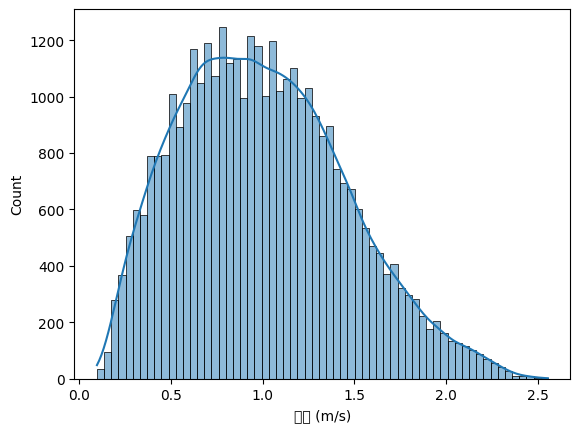

In [5]:
log = np.log1p(train['풍속 (m/s)'])
sns.histplot(log, kde=True)

In [6]:
features = train.dtypes[train.dtypes != 'object'].index

skew_features = train[features].apply(lambda x : skew(x))

#skew 정도가 1 이상인 칼럼만 추출
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

증기압 부족량(mbar)    2.374898
풍속 (m/s)         1.624866
포화 증기압(mbar)     1.287343
dtype: float64


In [7]:
train[skew_features_top.index] = np.log1p(train[skew_features_top.index])

#### 모델링 5

- 다른 전처리는 동일, 인코딩만 원핫인코딩으로 바꾼 후 LinearRegression+Ridge+Lasso 혼합 모델

In [8]:
#원핫인코딩
train = pd.concat([train, pd.get_dummies(train['측정 시간대'])], axis=1)
train = train.drop('측정 시간대', axis=1)
train.head(3)

,ID,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),풍속 (m/s),새벽,오전,오후,저녁
0,TRAIN_00000,7,2,13.97,287.78,9.84,76.1,992.08,2.832036,12.16,1.572774,7.66,1198.06,155.6,0.959350,0,0,0,1
1,TRAIN_00001,8,21,16.94,290.85,12.14,73.3,991.07,3.012098,14.17,1.818077,8.94,1183.67,177.0,0.985817,0,1,0,0
2,TRAIN_00002,11,1,9.76,283.84,5.40,74.2,988.71,2.572612,8.98,1.415853,5.67,1213.22,146.2,0.548121,0,0,0,1


In [9]:
test = pd.concat([test, pd.get_dummies(test['측정 시간대'])], axis=1)
test = test.drop('측정 시간대', axis=1)
test.head(3)

,ID,월,일,섭씨 온도(°⁣C),절대 온도(K),이슬점 온도(°C),상대 습도 (%),대기압(mbar),포화 증기압(mbar),실제 증기압(mbar),증기압 부족량(mbar),수증기 함량 (g/kg),공기 밀도 (g/m**3),풍향 (deg),새벽,오전,오후,저녁
0,TEST_00000,3,24,4.28,278.68,-0.21,72.5,984.48,8.30,6.02,2.28,3.81,1233.29,251.80,1,0,0,0
1,TEST_00001,9,24,13.40,286.81,10.36,81.8,996.98,15.40,12.59,2.80,7.89,1206.20,225.60,0,0,0,1
2,TEST_00002,5,28,19.89,294.33,14.95,73.2,984.83,23.26,17.03,6.23,10.82,1163.06,10.39,0,0,0,1


In [13]:
X_train_5 = train.drop(['ID', '풍속 (m/s)'], axis=1)
y_train_5 = train['풍속 (m/s)']
X_test = test.drop('ID', axis=1)

In [14]:
scaler = StandardScaler()
scaler.fit(X_train_5)
train_scaled = scaler.transform(X_train_5)

- 릿지와 라쏘의 최적 알파값 찾기

In [18]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [19]:
alphas = [0, 0.1, 1, 10, 100]

for alpha in alphas:
  ridge = Ridge(alpha=alpha)

  neg_mse_scores = cross_val_score(ridge, X_train_5, y_train_5, scoring='neg_mean_squared_error', cv=5)
  avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
  print('alpha {0}일 때, 5 folds의 평균 RMSE: {1:.3f}'.format(alpha, avg_rmse))

alpha 0일 때, 5 folds의 평균 RMSE: 0.394
alpha 0.1일 때, 5 folds의 평균 RMSE: 0.394
alpha 1일 때, 5 folds의 평균 RMSE: 0.395
alpha 10일 때, 5 folds의 평균 RMSE: 0.396
alpha 100일 때, 5 folds의 평균 RMSE: 0.397


In [20]:
def get_linear_reg_eval(model_name, params=None, X_data_n=None, y_target_n=None,
                        verbose=True, return_coeff=True):
  coeff_df = pd.DataFrame()
  if verbose: print('######', model_name, '######')
  for param in params:
    if model_name =='Ridge': model = Ridge(alpha=param)
    elif model_name =='Lasso': model = Lasso(alpha=param)
    neg_mse_scores = cross_val_score(model, X_data_n, y_target_n, scoring='neg_mean_squared_error', cv=5 )
    avg_rmse = np.mean(np.sqrt(-1*neg_mse_scores))
    print('alpha {0}일 때 5 folds의 평균 RMSE: {1:.3f}'.format(param, avg_rmse))

    #모델을 다시 학습하여 회귀 계수 추출
    model.fit(X_data_n, y_target_n)
    if return_coeff:
      coeff = pd.Series(data=model.coef_, index=X_data_n.columns)
      colname = 'alpha:'+str(param)
      coeff_df[colname] = coeff

  return coeff_df

In [21]:
lasso_alphas=[0.07, 0.1, 0.5, 1, 3]
coeff_lasso_df = get_linear_reg_eval('Lasso', params=lasso_alphas,
                                     X_data_n=X_train_5, y_target_n=y_train_5)

###### Lasso ######
alpha 0.07일 때 5 folds의 평균 RMSE: 0.412
alpha 0.1일 때 5 folds의 평균 RMSE: 0.412
alpha 0.5일 때 5 folds의 평균 RMSE: 0.422
alpha 1일 때 5 folds의 평균 RMSE: 0.429
alpha 3일 때 5 folds의 평균 RMSE: 0.453


릿지 알파는 100, 라쏘 알파는 3

In [22]:
lr_reg = LinearRegression()
lr_reg.fit(X_train_5, y_train_5)
ridge_reg = Ridge(alpha=100)
ridge_reg.fit(X_train_5, y_train_5)
lasso_reg = Lasso(alpha=3)
lasso_reg.fit(X_train_5, y_train_5)

Lasso(alpha=3)

In [23]:
lr_pred = lr_reg.predict(X_test)
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

pred_5 = 0.4 * lr_pred + 0.3 * ridge_pred + 0.3 * lasso_pred
preds_5 = {'최종 혼합': pred_5,
          'LinearRegression': lr_pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}

In [24]:
preds_5

{'최종 혼합': array([-28.02817406, -59.412124  , -95.1951952 , ..., -72.60527211,
        -25.20482904, -41.83929427]),
 'LinearRegression': array([ -71.32352007, -149.38753418, -238.42859376, ..., -182.13027708,
         -64.20557385, -105.84137621]),
 'Ridge': array([ 0.66813171,  0.14031741, -0.41517384, ..., -0.17985243,
         0.58868682,  0.65487256]),
 'Lasso': array([1.00264817, 1.00264817, 1.00264817, ..., 1.00264817, 1.00264817,
        1.00264817])}

In [25]:
pred_5

array([-28.02817406, -59.412124  , -95.1951952 , ..., -72.60527211,
       -25.20482904, -41.83929427])

In [26]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = pred_5
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,-28.028174
1,TEST_00001,-59.412124
2,TEST_00002,-95.195195
3,TEST_00003,-14.191742
4,TEST_00004,-35.301153


In [27]:
submission.to_csv('submission_5.csv', index=  False)

- 릿지 단일모델 예측 결과

In [30]:
submission = pd.read_csv('/content/sample_submission.csv')
submission['풍속 (m/s)'] = ridge_pred
submission.head()

,ID,풍속 (m/s)
0,TEST_00000,0.668132
1,TEST_00001,0.140317
2,TEST_00002,-0.415174
3,TEST_00003,0.697225
4,TEST_00004,0.756002


In [31]:
submission.to_csv('submission_6.csv', index=  False)